# Predicting a Stock Market Index with Deep Learning Models

## Group Identification
- João Martins - 20220526
- João Correia - 20221719
- Luís Veloso - 20220520
- Vitória Soares - 20221002

Data source: https://www.kaggle.com/datasets/mattiuzc/stock-exchange-data

Dataset Description (Kaggle): Daily Index Prices for Multiple Stock Exchanges

Task Definition: Develop a Deep Learning Model to predict the Tokyo Stock Exchange Index in the following day.   
Approach: Implement Deep Learning models suitable to deal with timeseries data such as RNNs, GRUs and LSTMS.

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # avoid useless tensorflow log messages 
import tensorflow as tf
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from ydata_profiling import ProfileReport

In [2]:
# Setting random seeds for the program
seed = 121
np.random.seed(seed) # for numpy
tf.keras.utils.set_random_seed(seed) # for tensorflow

## Data Loading

We will load the data from disk if it exists, otherwise we will download the data through Kaggle API.

In [3]:
try: # load data from files
    df_info = pd.read_csv("./data/indexInfo.csv") # df with information on the indices
    df = pd.read_csv("./data/indexData.csv") # df with index data (prices and volume)
    print("Data loaded from files.")
except: # if files not found or other errors
    # download it again from kaggle api
    # must have api access data in kaggle_api_key.py file
    import kaggle_api_key as kapik # import api keys from file

    os.environ["KAGGLE_USERNAME"] = kapik.username
    os.environ["KAGGLE_KEY"] = kapik.key

    from kaggle.api.kaggle_api_extended import KaggleApi

    api = KaggleApi()
    api.authenticate()
    # Download the files:
    api.dataset_download_files("mattiuzc/stock-exchange-data",
                               path="./data") # download to data folder in current working directory
    
    # extract it from doenloaded zip file
    # Zip extraction:
    with zipfile.ZipFile("./data/stock-exchange-data.zip", "r") as z:
        z.extractall("./data/") # extract everything to the data folder
    print("Data loaded from Kaggle.")

Data loaded from files.


## Data Exploration

### List of Indices Available

In [4]:
# indexInfo.csv file has information on the Stock Indexes available in the dataset
display(df_info.set_index("Index"))

Region                          Exchange Currency
Index                                                              
NYA        United States           New York Stock Exchange      USD
IXIC       United States                            NASDAQ      USD
HSI            Hong Kong          Hong Kong Stock Exchange      HKD
000001.SS          China           Shanghai Stock Exchange      CNY
N225               Japan              Tokyo Stock Exchange      JPY
N100              Europe                          Euronext      EUR
399001.SZ          China           Shenzhen Stock Exchange      CNY
GSPTSE            Canada            Toronto Stock Exchange      CAD
NSEI               India  National Stock Exchange of India      INR
GDAXI            Germany          Frankfurt Stock Exchange      EUR
KS11               Korea                    Korea Exchange      KRW
SSMI         Switzerland                SIX Swiss Exchange      CHF
TWII              Taiwan             Taiwan Stock Exchange      TWD
J203.JO     South Africa       Johannesburg Stock Exchange      ZAR

### Indices Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Date       112457 non-null  object 
 2   Open       110253 non-null  float64
 3   High       110253 non-null  float64
 4   Low        110253 non-null  float64
 5   Close      110253 non-null  float64
 6   Adj Close  110253 non-null  float64
 7   Volume     110253 non-null  float64
dtypes: float64(6), object(2)
memory usage: 6.9+ MB


In [6]:
df.describe(include='all').T

count unique         top   freq               mean  \
Index        112457     14        N225  14500                NaN   
Date         112457  14731  2017-11-03     14                NaN   
Open       110253.0    NaN         NaN    NaN        7658.515222   
High       110253.0    NaN         NaN    NaN        7704.372961   
Low        110253.0    NaN         NaN    NaN        7608.000422   
Close      110253.0    NaN         NaN    NaN        7657.545872   
Adj Close  110253.0    NaN         NaN    NaN        7657.351729   
Volume     110253.0    NaN         NaN    NaN  1273975162.603031   

                         std        min          25%          50%  \
Index                    NaN        NaN          NaN          NaN   
Date                     NaN        NaN          NaN          NaN   
Open             9011.478913  54.869999  1855.030029  5194.089844   
High             9066.638548  54.869999   1864.51001  5226.279785   
Low              8954.506981  54.869999   1843.97998  5154.049805   
Close            9011.510444  54.869999  1855.060059      5194.75   
Adj Close          9011.6089  54.869999  1854.179565      5194.75   
Volume     4315783120.880937        0.0          0.0     432900.0   

                   75%            max  
Index              NaN            NaN  
Date               NaN            NaN  
Open       10134.29981     68775.0625  
High       10207.82031       69403.75  
Low        10060.34961    68516.99219  
Close      10134.83008     68775.0625  
Adj Close  10134.83008     68775.0625  
Volume     173431400.0  94403740000.0

In [7]:
df.sample(5)

Index        Date          Open          High           Low  \
4563       NYA  1984-03-07    942.010010    942.010010    942.010010   
91234  J203.JO  2016-08-04  52532.761720  52842.421880  52404.488280   
16384     IXIC  1980-09-29    185.789993    185.789993    185.789993   
80880     SSMI  2008-10-13   5712.740234   5956.319824   5565.990234   
33906      HSI  2015-06-01  27373.060550  27766.320310  27241.949220   

              Close     Adj Close        Volume  
4563     942.010010    942.010010  0.000000e+00  
91234  52543.371090  52543.371090  0.000000e+00  
16384    185.789993    185.789993  0.000000e+00  
80880   5956.319824   5956.319824  1.787711e+08  
33906  27597.160160  27597.160160  1.972936e+09

#### Profiling of Raw Data

In [8]:
def get_profile(name, df, timeseries=False):
    '''
    Loads profile from file if already generated, otherwise generates the report.
    Returns the profile object.
    '''
    try: # load data from file if stored previously
        profile = ProfileReport()
        profile = profile.load('./profiles/'+name+'_profile.pp') # load from file
        print("Profile loaded from file.")
    except: # otherwise build it from scratch
        profile = ProfileReport(df, tsmode=timeseries)
        profile.to_file('./profiles/'+name+'_profile.html') # save report to html file
        profile.dump('./profiles/'+name+'_profile') # save object to profiles folder
        print("Profile built.")
    
    return profile 

In [9]:
profile_rd = get_profile('raw_data',df)

Profile loaded from file.


In [10]:
profile_rd.to_notebook_iframe() # display report in jupyter notebook

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Rework Raw Data into by Index

Manipulate dataframe to have a more workable format, since each stock index has its own set of variables (although similar).

In [11]:
# create new df with pivot table to change the logic of the data to a by index basis
df_new = df.pivot_table(index='Date', columns='Index')
df_new.head()

Adj Close                                                    \
Index      000001.SS 399001.SZ GDAXI GSPTSE HSI IXIC J203.JO KS11 N100   
Date                                                                     
1965-01-05       NaN       NaN   NaN    NaN NaN  NaN     NaN  NaN  NaN   
1965-01-06       NaN       NaN   NaN    NaN NaN  NaN     NaN  NaN  NaN   
1965-01-07       NaN       NaN   NaN    NaN NaN  NaN     NaN  NaN  NaN   
1965-01-08       NaN       NaN   NaN    NaN NaN  NaN     NaN  NaN  NaN   
1965-01-12       NaN       NaN   NaN    NaN NaN  NaN     NaN  NaN  NaN   

                         ... Volume                                            \
Index              N225  ...    HSI IXIC J203.JO KS11 N100 N225 NSEI NYA SSMI   
Date                     ...                                                    
1965-01-05  1257.719971  ...    NaN  NaN     NaN  NaN  NaN  0.0  NaN NaN  NaN   
1965-01-06  1263.989990  ...    NaN  NaN     NaN  NaN  NaN  0.0  NaN NaN  NaN   
1965-01-07  1274.270020  ...    NaN  NaN     NaN  NaN  NaN  0.0  NaN NaN  NaN   
1965-01-08  1286.430054  ...    NaN  NaN     NaN  NaN  NaN  0.0  NaN NaN  NaN   
1965-01-12  1288.540039  ...    NaN  NaN     NaN  NaN  NaN  0.0  NaN NaN  NaN   

                 
Index      TWII  
Date             
1965-01-05  NaN  
1965-01-06  NaN  
1965-01-07  NaN  
1965-01-08  NaN  
1965-01-12  NaN  

[5 rows x 84 columns]

In [12]:
df_new.columns # see which columns we got

MultiIndex([('Adj Close', '000001.SS'),
            ('Adj Close', '399001.SZ'),
            ('Adj Close',     'GDAXI'),
            ('Adj Close',    'GSPTSE'),
            ('Adj Close',       'HSI'),
            ('Adj Close',      'IXIC'),
            ('Adj Close',   'J203.JO'),
            ('Adj Close',      'KS11'),
            ('Adj Close',      'N100'),
            ('Adj Close',      'N225'),
            ('Adj Close',      'NSEI'),
            ('Adj Close',       'NYA'),
            ('Adj Close',      'SSMI'),
            ('Adj Close',      'TWII'),
            (    'Close', '000001.SS'),
            (    'Close', '399001.SZ'),
            (    'Close',     'GDAXI'),
            (    'Close',    'GSPTSE'),
            (    'Close',       'HSI'),
            (    'Close',      'IXIC'),
            (    'Close',   'J203.JO'),
            (    'Close',      'KS11'),
            (    'Close',      'N100'),
            (    'Close',      'N225'),
            (    'Close',      'NSEI'),


In [13]:
# swap column levels, to have the Stock Index placed first in the name of variables
df_new.columns = df_new.columns.swaplevel()
df_new

Index         000001.SS    399001.SZ        GDAXI       GSPTSE          HSI  \
              Adj Close    Adj Close    Adj Close    Adj Close    Adj Close   
Date                                                                          
1965-01-05          NaN          NaN          NaN          NaN          NaN   
1965-01-06          NaN          NaN          NaN          NaN          NaN   
1965-01-07          NaN          NaN          NaN          NaN          NaN   
1965-01-08          NaN          NaN          NaN          NaN          NaN   
1965-01-12          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2021-05-28  3600.780029  14852.87988  15519.98047  19852.19922  29124.41016   
2021-05-31  3615.479980  14996.37988  15421.12988  19731.00000  29151.80078   
2021-06-01          NaN  15034.78027          NaN          NaN          NaN   
2021-06-02          NaN  14857.91016          NaN          NaN          NaN   
2021-06-03          NaN          NaN          NaN          NaN          NaN   

Index              IXIC      J203.JO         KS11         N100          N225  \
              Adj Close    Adj Close    Adj Close    Adj Close     Adj Close   
Date                                                                           
1965-01-05          NaN          NaN          NaN          NaN   1257.719971   
1965-01-06          NaN          NaN          NaN          NaN   1263.989990   
1965-01-07          NaN          NaN          NaN          NaN   1274.270020   
1965-01-08          NaN          NaN          NaN          NaN   1286.430054   
1965-01-12          NaN          NaN          NaN          NaN   1288.540039   
...                 ...          ...          ...          ...           ...   
2021-05-28  13748.74023  67554.85938  3188.729980  1256.599976  29149.410160   
2021-05-31          NaN  67964.03906  3203.919922  1248.930054  28860.080080   
2021-06-01          NaN          NaN  3221.870117  1258.579956  28814.339840   
2021-06-02          NaN          NaN          NaN  1263.619995  28946.140630   
2021-06-03          NaN          NaN          NaN          NaN  29058.109380   

Index       ...           HSI          IXIC J203.JO       KS11         N100  \
            ...        Volume        Volume  Volume     Volume       Volume   
Date        ...                                                               
1965-01-05  ...           NaN           NaN     NaN        NaN          NaN   
1965-01-06  ...           NaN           NaN     NaN        NaN          NaN   
1965-01-07  ...           NaN           NaN     NaN        NaN          NaN   
1965-01-08  ...           NaN           NaN     NaN        NaN          NaN   
1965-01-12  ...           NaN           NaN     NaN        NaN          NaN   
...         ...           ...           ...     ...        ...          ...   
2021-05-28  ...  2.591560e+09  4.435220e+09     0.0   966000.0  160773400.0   
2021-05-31  ...  2.188581e+09           NaN     0.0  1123100.0   91173700.0   
2021-06-01  ...           NaN           NaN     NaN  1472570.0  155179900.0   
2021-06-02  ...           NaN           NaN     NaN        NaN  148465000.0   
2021-06-03  ...           NaN           NaN     NaN        NaN          NaN   

Index             N225      NSEI           NYA        SSMI       TWII  
                Volume    Volume        Volume      Volume     Volume  
Date                                                                   
1965-01-05         0.0       NaN           NaN         NaN        NaN  
1965-01-06         0.0       NaN           NaN         NaN        NaN  
1965-01-07         0.0       NaN           NaN         NaN        NaN  
1965-01-08         0.0       NaN           NaN         NaN        NaN  
1965-01-12         0.0       NaN           NaN         NaN        NaN  
...                ...       ...           ...         ...        ...  
2021-05-28  80600

In [14]:
df_new.columns # check if we have the opposite of the above after the swap

MultiIndex([('000001.SS', 'Adj Close'),
            ('399001.SZ', 'Adj Close'),
            (    'GDAXI', 'Adj Close'),
            (   'GSPTSE', 'Adj Close'),
            (      'HSI', 'Adj Close'),
            (     'IXIC', 'Adj Close'),
            (  'J203.JO', 'Adj Close'),
            (     'KS11', 'Adj Close'),
            (     'N100', 'Adj Close'),
            (     'N225', 'Adj Close'),
            (     'NSEI', 'Adj Close'),
            (      'NYA', 'Adj Close'),
            (     'SSMI', 'Adj Close'),
            (     'TWII', 'Adj Close'),
            ('000001.SS',     'Close'),
            ('399001.SZ',     'Close'),
            (    'GDAXI',     'Close'),
            (   'GSPTSE',     'Close'),
            (      'HSI',     'Close'),
            (     'IXIC',     'Close'),
            (  'J203.JO',     'Close'),
            (     'KS11',     'Close'),
            (     'N100',     'Close'),
            (     'N225',     'Close'),
            (     'NSEI',     'Close'),


In [15]:
df_info # Reviewing available indices

Region                          Exchange      Index Currency
0   United States           New York Stock Exchange        NYA      USD
1   United States                            NASDAQ       IXIC      USD
2       Hong Kong          Hong Kong Stock Exchange        HSI      HKD
3           China           Shanghai Stock Exchange  000001.SS      CNY
4           Japan              Tokyo Stock Exchange       N225      JPY
5          Europe                          Euronext       N100      EUR
6           China           Shenzhen Stock Exchange  399001.SZ      CNY
7          Canada            Toronto Stock Exchange     GSPTSE      CAD
8           India  National Stock Exchange of India       NSEI      INR
9         Germany          Frankfurt Stock Exchange      GDAXI      EUR
10          Korea                    Korea Exchange       KS11      KRW
11    Switzerland                SIX Swiss Exchange       SSMI      CHF
12         Taiwan             Taiwan Stock Exchange       TWII      TWD
13   South Africa       Johannesburg Stock Exchange    J203.JO      ZAR

In [16]:
# see which index has more observations, excluding missing values
obs_d = {"Index": list(),
         "N_obs": list()
        } # store it in a dictionary

for idx in df_info.Index.values:
    obs_d["Index"].append(idx)
    obs_d["N_obs"].append(len(df_new[[idx]].dropna()))

pd.DataFrame(obs_d).set_index("Index").sort_values("N_obs", ascending=False)

N_obs
Index           
NYA        13947
N225       13874
IXIC       12690
GSPTSE     10526
HSI         8492
GDAXI       8438
SSMI        7671
KS11        6029
TWII        5869
000001.SS   5791
399001.SZ   5760
N100        5474
NSEI        3346
J203.JO     2346

Analysing the two indices with the highest number of observations:

In [17]:
df_new[['NYA','N225']]

Index               NYA                                                      \
              Adj Close        Close         High          Low         Open   
Date                                                                          
1965-01-05          NaN          NaN          NaN          NaN          NaN   
1965-01-06          NaN          NaN          NaN          NaN          NaN   
1965-01-07          NaN          NaN          NaN          NaN          NaN   
1965-01-08          NaN          NaN          NaN          NaN          NaN   
1965-01-12          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2021-05-28  16555.66016  16555.66016  16588.68945  16531.94922  16531.94922   
2021-05-31          NaN          NaN          NaN          NaN          NaN   
2021-06-01          NaN          NaN          NaN          NaN          NaN   
2021-06-02          NaN          NaN          NaN          NaN          NaN   
2021-06-03          NaN          NaN          NaN          NaN          NaN   

Index                             N225                              \
                  Volume     Adj Close         Close          High   
Date                                                                 
1965-01-05           NaN   1257.719971   1257.719971   1257.719971   
1965-01-06           NaN   1263.989990   1263.989990   1263.989990   
1965-01-07           NaN   1274.270020   1274.270020   1274.270020   
1965-01-08           NaN   1286.430054   1286.430054   1286.430054   
1965-01-12           NaN   1288.540039   1288.540039   1288.540039   
...                  ...           ...           ...           ...   
2021-05-28  4.199270e+09  29149.410160  29149.410160  29194.109380   
2021-05-31           NaN  28860.080080  28860.080080  29147.710940   
2021-06-01           NaN  28814.339840  28814.339840  29075.470700   
2021-06-02           NaN  28946.140630  28946.140630  29003.550780   
2021-06-03           NaN  29058.109380  29058.109380  29157.160160   

Index                                               
                     Low          Open      Volume  
Date                                                
1965-01-05   1257.719971   1257.719971         0.0  
1965-01-06   1263.989990   1263.989990         0.0  
1965-01-07   1274.270020   1274.270020         0.0  
1965-01-08   1286.430054   1286.430054         0.0  
1965-01-12   1288.540039   1288.540039         0.0  
...                  ...           ...         ...  
2021-05-28  28899.660160  28912.539060  80600000.0  
2021-05-31  28791.599610  29019.449220  53800000.0  
2021-06-01  28611.250000  28998.650390  47400000.0  
2021-06-02  28565.830080  28730.810550  71000000.0  
2021-06-03  28879.150390  28890.390630         0.0  

[14657 rows x 12 columns]

For now we will deal with the N225 Index (Tokyo Stock Exchange), which is the index with data spanning across the longest period of time and a total number of observations (days) of 13874 (despite being slightly less than "NYA", probably due to differences in the number of holidays per year).

In [18]:
stock_index = 'N225' # chosen stock index

In [19]:
df_tokyo = df_new[[stock_index]].copy()
df_tokyo

Index               N225                                            \
               Adj Close         Close          High           Low   
Date                                                                 
1965-01-05   1257.719971   1257.719971   1257.719971   1257.719971   
1965-01-06   1263.989990   1263.989990   1263.989990   1263.989990   
1965-01-07   1274.270020   1274.270020   1274.270020   1274.270020   
1965-01-08   1286.430054   1286.430054   1286.430054   1286.430054   
1965-01-12   1288.540039   1288.540039   1288.540039   1288.540039   
...                  ...           ...           ...           ...   
2021-05-28  29149.410160  29149.410160  29194.109380  28899.660160   
2021-05-31  28860.080080  28860.080080  29147.710940  28791.599610   
2021-06-01  28814.339840  28814.339840  29075.470700  28611.250000   
2021-06-02  28946.140630  28946.140630  29003.550780  28565.830080   
2021-06-03  29058.109380  29058.109380  29157.160160  28879.150390   

Index                                 
                    Open      Volume  
Date                                  
1965-01-05   1257.719971         0.0  
1965-01-06   1263.989990         0.0  
1965-01-07   1274.270020         0.0  
1965-01-08   1286.430054         0.0  
1965-01-12   1288.540039         0.0  
...                  ...         ...  
2021-05-28  28912.539060  80600000.0  
2021-05-31  29019.449220  53800000.0  
2021-06-01  28998.650390  47400000.0  
2021-06-02  28730.810550  71000000.0  
2021-06-03  28890.390630         0.0  

[14657 rows x 6 columns]

In [20]:
# merge the two levels of column index to avoid having to deal with multi-level df
df_tokyo.columns = df_tokyo.columns.map('_'.join)

In [21]:
# check the resulting df
df_tokyo.sample(5)

N225_Adj Close    N225_Close     N225_High      N225_Low  \
Date                                                                   
1974-01-23     4453.979980   4453.979980   4453.979980   4453.979980   
1978-08-03     5556.720215   5556.720215   5556.720215   5556.720215   
2011-09-30     8700.290039   8700.290039   8756.000000   8653.620117   
1986-11-21    17489.580080  17489.580080  17489.580080  17489.580080   
2006-05-02    17153.769530  17153.769530  17188.539060  16900.330080   

               N225_Open  N225_Volume  
Date                                   
1974-01-23   4453.979980          0.0  
1978-08-03   5556.720215          0.0  
2011-09-30   8713.910156  148700000.0  
1986-11-21  17489.580080          0.0  
2006-05-02  16920.130860   89300000.0

In [22]:
profile_tokyo_ts = get_profile('tokyo_ts', df_tokyo, timeseries=True)

Profile loaded from file.


In [23]:
profile_tokyo_ts.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing Values

In [24]:
# show original missing values observations for the chosen stock index
(df[df[['Close']].isna().any(axis=1)]).loc[df.Index==stock_index,:] # mostly look like (Japanese) holidays

Index        Date  Open  High  Low  Close  Adj Close  Volume
92454   N225  1965-01-11   NaN   NaN  NaN    NaN        NaN     NaN
92458   N225  1965-01-15   NaN   NaN  NaN    NaN        NaN     NaN
92477   N225  1965-02-11   NaN   NaN  NaN    NaN        NaN     NaN
92504   N225  1965-03-22   NaN   NaN  NaN    NaN        NaN     NaN
92532   N225  1965-04-29   NaN   NaN  NaN    NaN        NaN     NaN
...      ...         ...   ...   ...  ...    ...        ...     ...
106294  N225  2018-09-24   NaN   NaN  NaN    NaN        NaN     NaN
106304  N225  2018-10-08   NaN   NaN  NaN    NaN        NaN     NaN
106338  N225  2018-11-23   NaN   NaN  NaN    NaN        NaN     NaN
106359  N225  2018-12-24   NaN   NaN  NaN    NaN        NaN     NaN
106364  N225  2018-12-31   NaN   NaN  NaN    NaN        NaN     NaN

[626 rows x 8 columns]

In [25]:
# see when volume starts being different from zero
df_tokyo[df_tokyo.N225_Volume>0]

N225_Adj Close   N225_Close    N225_High     N225_Low  \
Date                                                                
2002-06-10     11370.20996  11370.20996  11522.04004  11370.20996   
2002-06-11     11449.44043  11449.44043  11514.53027  11390.41016   
2002-06-12     11327.05957  11327.05957  11405.29004  11261.92969   
2002-06-13     11144.83984  11144.83984  11396.28027  11132.58984   
2002-06-14     10920.62988  10920.62988  11127.16016  10911.07031   
...                    ...          ...          ...          ...   
2021-05-27     28549.00977  28549.00977  28587.21094  28360.56055   
2021-05-28     29149.41016  29149.41016  29194.10938  28899.66016   
2021-05-31     28860.08008  28860.08008  29147.71094  28791.59961   
2021-06-01     28814.33984  28814.33984  29075.47070  28611.25000   
2021-06-02     28946.14063  28946.14063  29003.55078  28565.83008   

              N225_Open  N225_Volume  
Date                                  
2002-06-10  11470.91992   37900000.0  
2002-06-11  11390.41016   39600000.0  
2002-06-12  11392.32031   42800000.0  
2002-06-13  11366.05957   46500000.0  
2002-06-14  11121.88965  112800000.0  
...                 ...          ...  
2021-05-27  28543.32031  138200000.0  
2021-05-28  28912.53906   80600000.0  
2021-05-31  29019.44922   53800000.0  
2021-06-01  28998.65039   47400000.0  
2021-06-02  28730.81055   71000000.0  

[4635 rows x 6 columns]

Only have volume values from 2002/06/10.

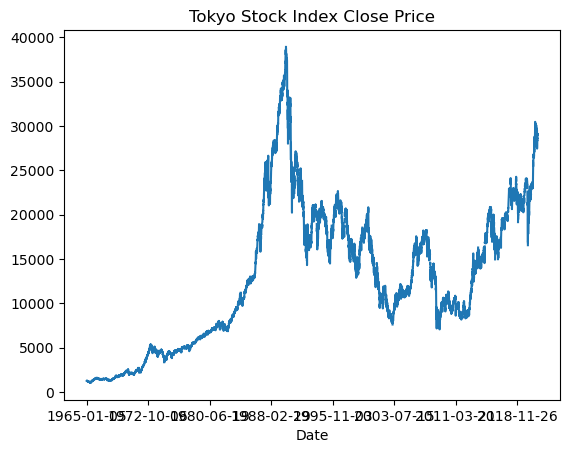

In [26]:
# plot close price
df_tokyo[stock_index+'_Close'].plot(title="Tokyo Stock Index Close Price");

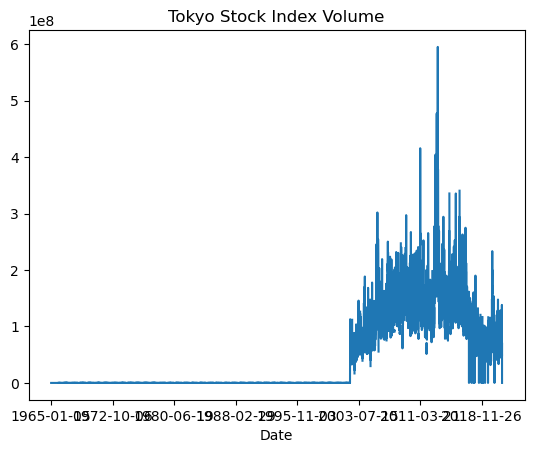

In [27]:
# plot volume
df_tokyo[stock_index+'_Volume'].plot(title="Tokyo Stock Index Volume");

## Preprocessing

In [28]:
type(df_tokyo.index)

pandas.core.indexes.base.Index

The dataframe index is not in datetime format, so we have to convert it.

In [29]:
# convert df index to datetime format
df_tokyo.index = pd.to_datetime(df_tokyo.index)

# check it was successful
type(df_tokyo.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [30]:
# stock_idx = 'N225' # stock index
# df_tokyo = dfi[[x for x in dfi.columns if stock_idx in x]].copy()
# df_tokyo

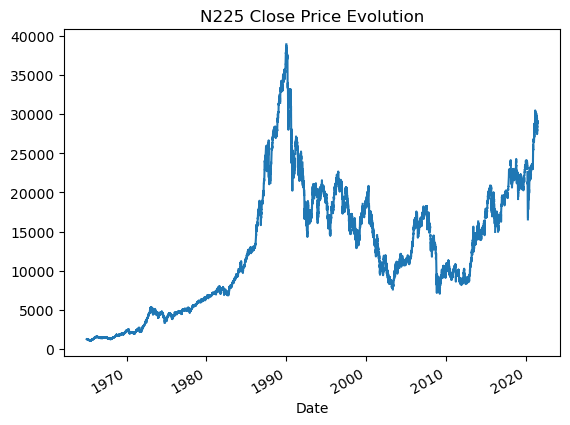

In [31]:
df_tokyo[stock_index+'_Close'].plot(title=stock_index+' Close Price Evolution');

We will predict the Close Price.

In [32]:
tokyo_close = df_tokyo[[stock_index+'_Close']].copy()
tokyo_close

N225_Close
Date                    
1965-01-05   1257.719971
1965-01-06   1263.989990
1965-01-07   1274.270020
1965-01-08   1286.430054
1965-01-12   1288.540039
...                  ...
2021-05-28  29149.410160
2021-05-31  28860.080080
2021-06-01  28814.339840
2021-06-02  28946.140630
2021-06-03  29058.109380

[14657 rows x 1 columns]

In [33]:
tokyo_close.shape

(14657, 1)

### Missing Values

In [34]:
# remove missing values
tokyo_close = tokyo_close.dropna()

In [35]:
tokyo_close.shape

(13874, 1)

### Train Test Split

In [36]:
test_pct = 0.05 # percentage of data for validation and test (each)
split_time = int(test_pct*len(tokyo_close))

train = tokyo_close[:-split_time]
test = tokyo_close[-split_time:]

# Remove last days of the training dataset for validation:
val = train[-split_time:]
train = train[:-split_time]

print(f"Shape of train data: {train.shape}")
print(f"Shape of val data: {val.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (12488, 1)
Shape of val data: (693, 1)
Shape of test data: (693, 1)


In [37]:
split_time # in days

693

In [38]:
# in years (assuming 250 trading days per year)
split_time/250

2.772

In [39]:
# from class
plt.figure(figsize=(9,4))
plt.plot(train, color="lightblue")
plt.plot(val, color="lightgreen")
plt.plot(test, color="yellow")
plt.title("Open stock prices - train, val and test")
#plt.legend()
plt.show()

### Normalization

In [40]:
# code from class
# standardize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(clip=True)

train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
print(f"Shape of train: {train.shape}")
print(f"Shape of val: {val.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (12488, 1)
Shape of val: (693, 1)
Shape of test: (693, 1)


In [41]:
# Import TimeseriesGenerator from Tensorflow Keras to work with time series data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [42]:
timesteps = 30  # number of time steps to look back
batch_size = 32  # number of samples per batch

train_generator = TimeseriesGenerator(train, train, length=timesteps, batch_size=batch_size)
val_generator = TimeseriesGenerator(val, val, length=timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test, test, length=timesteps, batch_size=batch_size)

## Modelling

In [43]:
# Shared attributes:
loss_function = 'mse'  # other options: mse, rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
epochs = 50

num_samples, num_input_features = train.shape

print(num_input_features)

1


In [44]:
# define function to get trained model

from keras.callbacks import CSVLogger

def get_trained_model(name, model, train_generator, val_generator):
    '''
    Function that gives the results from a trained model if it already exists in disk memory,
    otherwise it will train the model.
    '''
    try:
        # first we try to load the model already trained and its history from disk
        model = tf.keras.models.load_model('./models/'+name+'.h5') # loading the model back from the disk
        # loading model history from file as explained in the stackoverflow link below
        history = pd.read_csv('./models/'+name+'_training.log', sep=',', engine='python')
        print(name+" and its history loaded from disk.")
    except:
        # however if it's not possible, we will train the model
        
        # Setting the logs file where to save the model's history, according to solution found in stackoverflow
        #  Link: https://stackoverflow.com/questions/47843265/how-can-i-get-a-keras-models-history-after-loading-it-from-a-file-in-python?rq=3
        csv_logger = CSVLogger(# save training history in models folder
                               './models/'+\
                               name+'_training.log', separator=',', append=False)
        
        # train model
        history = model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=epochs,
                            callbacks=[csv_logger])
        
        history = history.history # only return history of train
        
        # save model in models folder
        model.save('./models/'+name+'.h5')
        
        print('\n'+name+" trained and saved to disk.")
    
    return model, history

### Round 1

#### Simple RNN

In [45]:
# Define RNN's architecture here:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model.add(Dense(1))

rnn_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            16640     
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [46]:
rnn_model, rnn_history = get_trained_model('rnn_model', rnn_model, train_generator, val_generator)

Epoch 1/50
390/390 [==============================] - 7s 15ms/step - loss: 0.0035 - rmse: 0.0588 - mae: 0.0330 - val_loss: 8.0549e-04 - val_rmse: 0.0284 - val_mae: 0.0211
Epoch 2/50
390/390 [==============================] - 6s 14ms/step - loss: 7.8792e-04 - rmse: 0.0281 - mae: 0.0179 - val_loss: 5.2977e-04 - val_rmse: 0.0230 - val_mae: 0.0171
Epoch 3/50
390/390 [==============================] - 6s 16ms/step - loss: 5.8306e-04 - rmse: 0.0241 - mae: 0.0157 - val_loss: 7.5174e-04 - val_rmse: 0.0274 - val_mae: 0.0215
Epoch 4/50
390/390 [==============================] - 6s 16ms/step - loss: 5.7988e-04 - rmse: 0.0241 - mae: 0.0158 - val_loss: 7.2002e-04 - val_rmse: 0.0268 - val_mae: 0.0206
Epoch 5/50
390/390 [==============================] - 7s 17ms/step - loss: 4.9329e-04 - rmse: 0.0222 - mae: 0.0142 - val_loss: 5.3651e-04 - val_rmse: 0.0232 - val_mae: 0.0182
Epoch 6/50
390/390 [==============================] - 5s 14ms/step - loss: 6.1339e-04 - rmse: 0.0248 - mae: 0.0168 - val_loss: 0.

In [47]:
# code adapted from professor
def evaluate_model(model, model_name, train_gen, val_gen, test_gen, verbose=False):
    """Utility function that prints loss and metrics of a given model. Returns the results in a dataframe."""
    if verbose:
        print(f"Evaluation of {model_name}:")
    
    train_loss, train_rmse, train_mae = model.evaluate(train_gen)
    val_loss, val_rmse, val_mae = model.evaluate(val_gen)
    test_loss, test_rmse, test_mae = model.evaluate(test_gen)
    
    if verbose:
        print(f"\nTest loss: {round(test_loss, 4)} \t | \ttest rmse: {round(test_rmse, 4)}"+\
              f" \t | \ttest mae: {round(test_mae, 4)}")
        print(f"Val loss: {round(val_loss, 4)} \t | \tval rmse: {round(val_rmse, 4)}"+\
             f" \t | \tval mae: {round(val_mae, 4)}")
        print(f"Train loss: {round(train_loss, 4)} \t | \ttrain rmse: {round(train_rmse, 4)}"+\
              f" \t | \ttrain mae: {round(train_mae, 4)}")
        
    return pd.DataFrame.from_dict(
        [
            {
                "model_name": model_name,
                "test_loss": round(test_loss, 4),
                "test_rmse": round(test_rmse, 4),
                "test_mae": round(test_mae, 4),
                "val_loss": round(val_loss, 4),
                "val_rmse": round(val_rmse, 4),
                "val_mae": round(val_mae, 4),
                "train_loss": round(train_loss, 4),
                "train_rmse": round(train_rmse, 4),
                "train_mae": round(train_mae, 4)
            }
        ]
    )

In [48]:
results_rnn = evaluate_model(
    rnn_model,
    "RNN_MODEL",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn

Evaluation of RNN_MODEL:
21/21 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0345 - mae: 0.0257

Test loss: 0.0012 	 | 	test rmse: 0.0345 	 | 	test mae: 0.0257
Val loss: 0.0006 	 | 	val rmse: 0.0239 	 | 	val mae: 0.019
Train loss: 0.0005 	 | 	train rmse: 0.0219 	 | 	train mae: 0.0162


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
0  RNN_MODEL     0.0012     0.0345    0.0257    0.0006    0.0239    0.019   

   train_loss  train_rmse  train_mae  
0      0.0005      0.0219     0.0162

In [49]:
def generate_predictions(model, train_data, validation_data, test_data):
    train_preds = model.predict(train_data)
    val_preds = model.predict(validation_data)
    test_preds = model.predict(test_data)

    print(f"Shape of train_preds: {train_preds.shape}")
    print(f"Shape of val_preds: {val_preds.shape}")
    
    return train_preds, val_preds, test_preds

In [50]:
rnn_train_preds, rnn_val_preds, rnn_test_preds = generate_predictions(rnn_model, train, val, test)

22/22 [==============================] - 0s 2ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


In [51]:
# The batch returns 2 arrays: features and targets
batch = train_generator[0]

lookback = len(batch[0][0])
num_days_being_predicted = len(batch[1][0])

print(f"The batch returns {len(batch)} arrays, corresponding to the X (features) and y (targets).")
print(f"The input sequences have length = {lookback}, meaning that our lookback is {lookback} days.")
print(f"Our target array has length = {num_days_being_predicted}, meaning that we are using the past {lookback} days to predict the next {num_days_being_predicted} day(s).")

The batch returns 2 arrays, corresponding to the X (features) and y (targets).
The input sequences have length = 30, meaning that our lookback is 30 days.
Our target array has length = 1, meaning that we are using the past 30 days to predict the next 1 day(s).


In [52]:
def plot_predictions(tokyo_close, train, val, test,
                     train_preds, val_preds, test_preds,
                     title, vars_to_plot=["train_preds", "val_preds", "test_preds", "train", "val", "test"]):
    '''
    Plot Predictions with train, validation, and test data
    '''
    data_dict = {
                 "train": train, "val": val, "test": test,
                 "train_preds": train_preds.ravel(), "val_preds": val_preds.ravel(), "test_preds": test_preds.ravel()
                }

    datetime_indexes = {
                        "train": tokyo_close[:-split_time*2].index,
                        "train_preds": tokyo_close[:-split_time*2].index,
                        "val": tokyo_close[-split_time * 2: -split_time].index,
                        "val_preds": tokyo_close[-split_time * 2: -split_time].index,
                        "test": tokyo_close[-split_time:].index,
                        "test_preds": tokyo_close[-split_time:].index
                        }
    
    color_code = {
                  "train": "lightblue",
                  "val": "lightgreen",
                  "test": "yellow",
                  "train_preds": "darkblue",
                  "val_preds": "darkgreen",
                  "test_preds": "orange"
                  }
    
    plt.figure(figsize=(12,4))
    
    for col in vars_to_plot:
        plt.plot(datetime_indexes[col], data_dict[col], color=color_code[col])
        
    
    plt.title(title)
    plt.show()

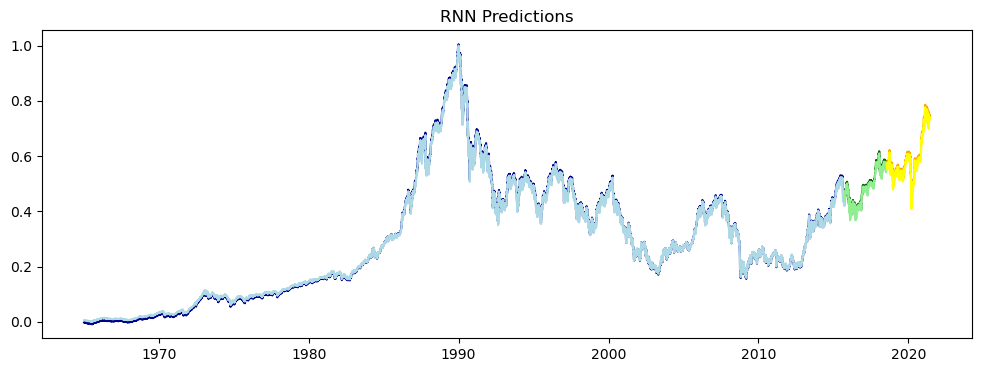

In [53]:
plot_predictions(tokyo_close, train, val, test, rnn_train_preds, rnn_val_preds, rnn_test_preds, "RNN Predictions")

In [54]:
# adapted from Professor's code
def plot_model_performance(history, model_name, metric='rmse'):
    val_metric = 'val_' + metric
        
    model_train_values = history[metric]
    model_val_values = history[val_metric]
        
    epochs = range(1, len(model_train_values) + 1)
        
    plt.figure(figsize=(10,4))
    ax = plt.plot(epochs, model_train_values, color='blue', label=f'Training {metric.upper()}')
    plt.plot(epochs, model_val_values, color='orange', label=f'Validation {metric.upper()}')
    plt.xlabel("Epoch")
    
    plt.title(f'{model_name} performance')
    plt.legend()

In [55]:
plot_model_performance(rnn_history, 'RNN')

#### GRU (Gated Recurrent Unit)

In [56]:
# Define GRU Architecture
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(GRU(units=128, input_shape=(num_input_features, 1), return_sequences=True))
gru_model.add(Dense(1))

gru_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            50304     
                                                                 
 dense_1 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [57]:
gru_model, gru_history = get_trained_model('gru_model', gru_model, train_generator, val_generator)

Epoch 1/50
390/390 [==============================] - 17s 39ms/step - loss: 0.0032 - rmse: 0.0553 - mae: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0339 - val_mae: 0.0219
Epoch 2/50
390/390 [==============================] - 13s 32ms/step - loss: 9.3680e-04 - rmse: 0.0306 - mae: 0.0201 - val_loss: 7.8404e-04 - val_rmse: 0.0280 - val_mae: 0.0213
Epoch 3/50
390/390 [==============================] - 14s 36ms/step - loss: 5.9135e-04 - rmse: 0.0243 - mae: 0.0163 - val_loss: 0.0015 - val_rmse: 0.0391 - val_mae: 0.0348
Epoch 4/50
390/390 [==============================] - 13s 33ms/step - loss: 5.6334e-04 - rmse: 0.0237 - mae: 0.0162 - val_loss: 4.8373e-04 - val_rmse: 0.0220 - val_mae: 0.0164
Epoch 5/50
390/390 [==============================] - 14s 36ms/step - loss: 5.8401e-04 - rmse: 0.0242 - mae: 0.0164 - val_loss: 4.5264e-04 - val_rmse: 0.0213 - val_mae: 0.0156
Epoch 6/50
390/390 [==============================] - 13s 34ms/step - loss: 5.2359e-04 - rmse: 0.0229 - mae: 0.0151 - val_loss: 4.76

In [58]:
# code from class
results_gru = evaluate_model(gru_model,
                             "GRU_MODEL",
                             train_generator,
                             val_generator,
                             test_generator,
                             verbose=True
                            )

results_gru

Evaluation of GRU_MODEL:
21/21 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0322 - mae: 0.0222

Test loss: 0.001 	 | 	test rmse: 0.0322 	 | 	test mae: 0.0222
Val loss: 0.0005 	 | 	val rmse: 0.0214 	 | 	val mae: 0.0158
Train loss: 0.0004 	 | 	train rmse: 0.0194 	 | 	train mae: 0.0121


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
0  GRU_MODEL      0.001     0.0322    0.0222    0.0005    0.0214   0.0158   

   train_loss  train_rmse  train_mae  
0      0.0004      0.0194     0.0121

In [59]:
gru_train_preds, gru_val_preds, gru_test_preds = generate_predictions(gru_model, train, val, test)

22/22 [==============================] - 0s 2ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


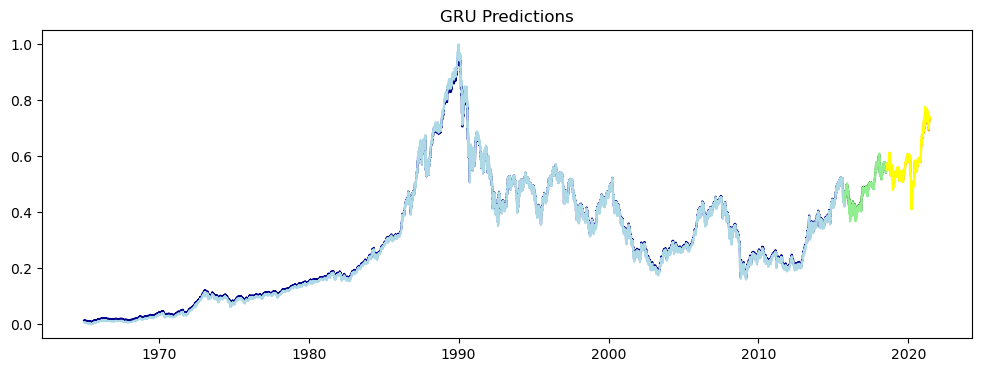

In [60]:
plot_predictions(tokyo_close, train, val, test, gru_train_preds, gru_val_preds, gru_test_preds, "GRU Predictions")

In [61]:
plot_model_performance(gru_history, 'GRU')

#### LSTM (Long Short-Term Memory)

In [62]:
# Define LSTM's architecture
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model.add(Dense(1))

lstm_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dense_2 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [63]:
lstm_model, lstm_history = get_trained_model('lstm_model', lstm_model, train_generator, val_generator)

Epoch 1/50
390/390 [==============================] - 15s 34ms/step - loss: 0.0063 - rmse: 0.0776 - mae: 0.0408 - val_loss: 0.0034 - val_rmse: 0.0584 - val_mae: 0.0323
Epoch 2/50
390/390 [==============================] - 14s 36ms/step - loss: 0.0017 - rmse: 0.0415 - mae: 0.0226 - val_loss: 0.0015 - val_rmse: 0.0386 - val_mae: 0.0241
Epoch 3/50
390/390 [==============================] - 13s 34ms/step - loss: 0.0012 - rmse: 0.0343 - mae: 0.0215 - val_loss: 8.6309e-04 - val_rmse: 0.0294 - val_mae: 0.0189
Epoch 4/50
390/390 [==============================] - 14s 35ms/step - loss: 7.1870e-04 - rmse: 0.0268 - mae: 0.0164 - val_loss: 0.0016 - val_rmse: 0.0397 - val_mae: 0.0347
Epoch 5/50
390/390 [==============================] - 15s 39ms/step - loss: 7.2489e-04 - rmse: 0.0269 - mae: 0.0178 - val_loss: 5.6857e-04 - val_rmse: 0.0238 - val_mae: 0.0179
Epoch 6/50
390/390 [==============================] - 14s 36ms/step - loss: 5.5282e-04 - rmse: 0.0235 - mae: 0.0157 - val_loss: 0.0011 - val_rms

In [64]:
results_lstm = evaluate_model(lstm_model,
                             "LSTM_MODEL",
                             train_generator,
                             val_generator,
                             test_generator,
                             verbose=True
                            )

results_lstm

Evaluation of LSTM_MODEL:
21/21 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0350 - mae: 0.0265

Test loss: 0.0012 	 | 	test rmse: 0.035 	 | 	test mae: 0.0265
Val loss: 0.0006 	 | 	val rmse: 0.0242 	 | 	val mae: 0.0194
Train loss: 0.0005 	 | 	train rmse: 0.0212 	 | 	train mae: 0.0147


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
0  LSTM_MODEL     0.0012      0.035    0.0265    0.0006    0.0242   0.0194   

   train_loss  train_rmse  train_mae  
0      0.0005      0.0212     0.0147

In [65]:
lstm_train_preds, lstm_val_preds, lstm_test_preds = generate_predictions(lstm_model, train, val, test)

22/22 [==============================] - 0s 2ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


In [66]:
plot_predictions(tokyo_close, train, val, test, lstm_train_preds, lstm_val_preds, lstm_test_preds, "LSTM Predictions")

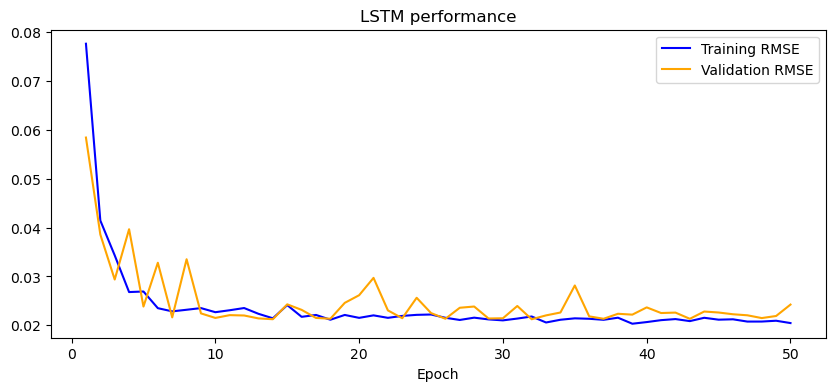

In [67]:
plot_model_performance(lstm_history, 'LSTM')

#### Results Summary - Round 1

In [68]:
results = pd.concat([results_rnn, results_gru, results_lstm]).set_index("model_name")
results

test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
model_name                                                                
RNN_MODEL      0.0012     0.0345    0.0257    0.0006    0.0239   0.0190   
GRU_MODEL      0.0010     0.0322    0.0222    0.0005    0.0214   0.0158   
LSTM_MODEL     0.0012     0.0350    0.0265    0.0006    0.0242   0.0194   

            train_loss  train_rmse  train_mae  
model_name                                     
RNN_MODEL       0.0005      0.0219     0.0162  
GRU_MODEL       0.0004      0.0194     0.0121  
LSTM_MODEL      0.0005      0.0212     0.0147

### Round 2

Increase the batch size to 64.

#### Simple RNN

In [69]:
timesteps = 30  # number of time steps to look back
batch_size_64 = 64  # number of samples per batch

train_generator_64 = TimeseriesGenerator(train, train, length=timesteps, batch_size=batch_size_64)
val_generator_64 = TimeseriesGenerator(val, val, length=timesteps, batch_size=batch_size)
test_generator_64 = TimeseriesGenerator(test, test, length=timesteps, batch_size=batch_size)

In [70]:
# Define RNN's architecture here:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense

rnn_model_64 = Sequential()
rnn_model_64.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model_64.add(Dense(1))

rnn_model_64.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model_64.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_3 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [71]:
rnn_model_64, rnn_history_64 = get_trained_model('rnn_model_b64', rnn_model_64,
                                                 train_generator_64, val_generator_64)

Epoch 1/50
195/195 [==============================] - 5s 20ms/step - loss: 0.0033 - rmse: 0.0561 - mae: 0.0333 - val_loss: 0.0026 - val_rmse: 0.0507 - val_mae: 0.0456
Epoch 2/50
195/195 [==============================] - 4s 19ms/step - loss: 7.3639e-04 - rmse: 0.0271 - mae: 0.0176 - val_loss: 5.9782e-04 - val_rmse: 0.0245 - val_mae: 0.0190
Epoch 3/50
195/195 [==============================] - 4s 18ms/step - loss: 6.3432e-04 - rmse: 0.0252 - mae: 0.0171 - val_loss: 5.2527e-04 - val_rmse: 0.0229 - val_mae: 0.0168
Epoch 4/50
195/195 [==============================] - 3s 17ms/step - loss: 5.9374e-04 - rmse: 0.0244 - mae: 0.0171 - val_loss: 4.5285e-04 - val_rmse: 0.0213 - val_mae: 0.0157
Epoch 5/50
195/195 [==============================] - 4s 19ms/step - loss: 6.4984e-04 - rmse: 0.0255 - mae: 0.0164 - val_loss: 4.7232e-04 - val_rmse: 0.0217 - val_mae: 0.0160
Epoch 6/50
195/195 [==============================] - 4s 18ms/step - loss: 5.6194e-04 - rmse: 0.0237 - mae: 0.0158 - val_loss: 5.1726

In [72]:
results_rnn_b64 = evaluate_model(
    rnn_model_64,
    "RNN_MODEL_b64",
    train_generator_64,
    val_generator_64,
    test_generator_64,
    verbose=True 
)

results_rnn_b64

Evaluation of RNN_MODEL_b64:
21/21 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0375 - mae: 0.0295

Test loss: 0.0014 	 | 	test rmse: 0.0375 	 | 	test mae: 0.0295
Val loss: 0.0006 	 | 	val rmse: 0.0249 	 | 	val mae: 0.0201
Train loss: 0.0005 	 | 	train rmse: 0.0214 	 | 	train mae: 0.0138


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
0  RNN_MODEL_b64     0.0014     0.0375    0.0295    0.0006    0.0249   0.0201   

   train_loss  train_rmse  train_mae  
0      0.0005      0.0214     0.0138

In [73]:
rnn_64_train_preds, rnn_64_val_preds, rnn_64_test_preds = generate_predictions(rnn_model_64,
                                                                               train, val, test)

22/22 [==============================] - 0s 2ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


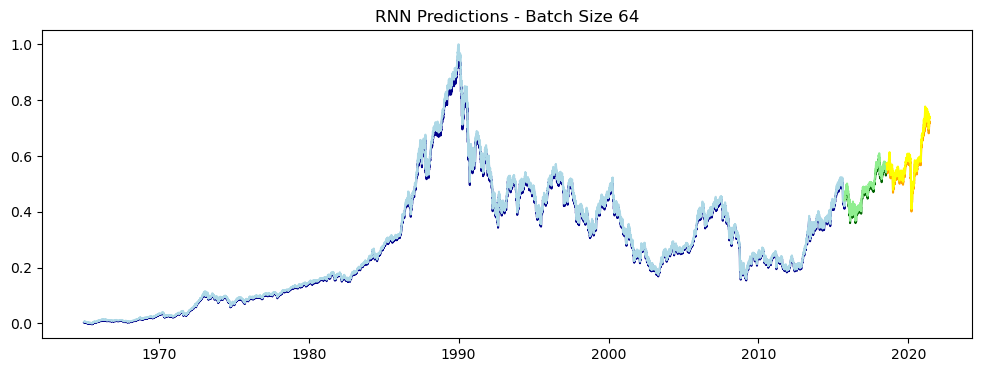

In [74]:
plot_predictions(tokyo_close, train, val, test, rnn_64_train_preds, rnn_64_val_preds, rnn_64_test_preds, "RNN Predictions - Batch Size 64")

In [75]:
plot_model_performance(rnn_history_64, 'RNN - Batch Size 64')

#### GRU

In [76]:
# Define GRU Architecture
from tensorflow.keras.layers import GRU

gru_model_64 = Sequential()
gru_model_64.add(GRU(units=128, input_shape=(num_input_features, 1), return_sequences=True))
gru_model_64.add(Dense(1))

gru_model_64.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
gru_model_64.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 128)            50304     
                                                                 
 dense_4 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [77]:
gru_model_64, gru_history_64 = get_trained_model('gru_model_b64', gru_model_64, train_generator_64, val_generator_64)

Epoch 1/50
195/195 [==============================] - 11s 48ms/step - loss: 0.0046 - rmse: 0.0663 - mae: 0.0358 - val_loss: 0.0020 - val_rmse: 0.0444 - val_mae: 0.0235
Epoch 2/50
195/195 [==============================] - 9s 45ms/step - loss: 0.0012 - rmse: 0.0348 - mae: 0.0208 - val_loss: 0.0010 - val_rmse: 0.0316 - val_mae: 0.0195
Epoch 3/50
195/195 [==============================] - 9s 45ms/step - loss: 8.7814e-04 - rmse: 0.0296 - mae: 0.0187 - val_loss: 7.0025e-04 - val_rmse: 0.0265 - val_mae: 0.0179
Epoch 4/50
195/195 [==============================] - 9s 45ms/step - loss: 7.4759e-04 - rmse: 0.0273 - mae: 0.0180 - val_loss: 6.9155e-04 - val_rmse: 0.0263 - val_mae: 0.0200
Epoch 5/50
195/195 [==============================] - 9s 43ms/step - loss: 7.0755e-04 - rmse: 0.0266 - mae: 0.0185 - val_loss: 5.1539e-04 - val_rmse: 0.0227 - val_mae: 0.0165
Epoch 6/50
195/195 [==============================] - 8s 43ms/step - loss: 5.3224e-04 - rmse: 0.0231 - mae: 0.0155 - val_loss: 5.1993e-04 - 

In [78]:
# code from class
results_gru_b64 = evaluate_model(
    gru_model_64,
    "GRU_MODEL_b64",
    train_generator_64,
    val_generator_64,
    test_generator_64,
    verbose=True 
)

results_gru_b64

Evaluation of GRU_MODEL_b64:
21/21 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0324 - mae: 0.0225

Test loss: 0.001 	 | 	test rmse: 0.0324 	 | 	test mae: 0.0225
Val loss: 0.0005 	 | 	val rmse: 0.0216 	 | 	val mae: 0.0161
Train loss: 0.0004 	 | 	train rmse: 0.0193 	 | 	train mae: 0.0115


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
0  GRU_MODEL_b64      0.001     0.0324    0.0225    0.0005    0.0216   0.0161   

   train_loss  train_rmse  train_mae  
0      0.0004      0.0193     0.0115

In [79]:
gru_64_train_preds, gru_64_val_preds, gru_64_test_preds = generate_predictions(gru_model_64, train, val, test)

22/22 [==============================] - 0s 3ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


In [80]:
plot_predictions(tokyo_close, train, val, test,
                 gru_64_train_preds, gru_64_val_preds, gru_64_test_preds,
                 "GRU Predictions - Batch Size 64")

In [81]:
plot_model_performance(gru_history_64, 'GRU - Batch Size 64')

#### LSTM

In [82]:
# Define LSTM's architecture
from tensorflow.keras.layers import LSTM

lstm_model_64 = Sequential()
lstm_model_64.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model_64.add(Dense(1))

lstm_model_64.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model_64.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_5 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [83]:
lstm_model_64, lstm_history_64 = get_trained_model('lstm_model_b64', lstm_model_64,
                                                   train_generator_64, val_generator_64)

Epoch 1/50
195/195 [==============================] - 11s 51ms/step - loss: 0.0118 - rmse: 0.1060 - mae: 0.0559 - val_loss: 0.0069 - val_rmse: 0.0833 - val_mae: 0.0428
Epoch 2/50
195/195 [==============================] - 9s 46ms/step - loss: 0.0037 - rmse: 0.0605 - mae: 0.0327 - val_loss: 0.0039 - val_rmse: 0.0624 - val_mae: 0.0303
Epoch 3/50
195/195 [==============================] - 9s 46ms/step - loss: 0.0023 - rmse: 0.0475 - mae: 0.0256 - val_loss: 0.0026 - val_rmse: 0.0510 - val_mae: 0.0299
Epoch 4/50
195/195 [==============================] - 9s 48ms/step - loss: 0.0017 - rmse: 0.0407 - mae: 0.0222 - val_loss: 0.0032 - val_rmse: 0.0566 - val_mae: 0.0467
Epoch 5/50
195/195 [==============================] - 10s 51ms/step - loss: 0.0013 - rmse: 0.0358 - mae: 0.0209 - val_loss: 0.0015 - val_rmse: 0.0382 - val_mae: 0.0268
Epoch 6/50
195/195 [==============================] - 8s 42ms/step - loss: 0.0010 - rmse: 0.0322 - mae: 0.0189 - val_loss: 9.2952e-04 - val_rmse: 0.0305 - val_mae:

In [84]:
results_lstm_b64 = evaluate_model(lstm_model_64, "LSTM_MODEL_b64",
                                  train_generator_64, val_generator_64,test_generator_64,
                                  verbose=True)
results_lstm_b64

Evaluation of LSTM_MODEL_b64:
21/21 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0318 - mae: 0.0213

Test loss: 0.001 	 | 	test rmse: 0.0318 	 | 	test mae: 0.0213
Val loss: 0.0005 	 | 	val rmse: 0.0214 	 | 	val mae: 0.0157
Train loss: 0.0004 	 | 	train rmse: 0.0197 	 | 	train mae: 0.0122


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  \
0  LSTM_MODEL_b64      0.001     0.0318    0.0213    0.0005    0.0214   

   val_mae  train_loss  train_rmse  train_mae  
0   0.0157      0.0004      0.0197     0.0122

In [85]:
lstm_64_train_preds, lstm_64_val_preds, lstm_64_test_preds = generate_predictions(lstm_model_64, train, val, test)

22/22 [==============================] - 0s 2ms/step
Shape of train_preds: (12488, 1, 1)
Shape of val_preds: (693, 1, 1)


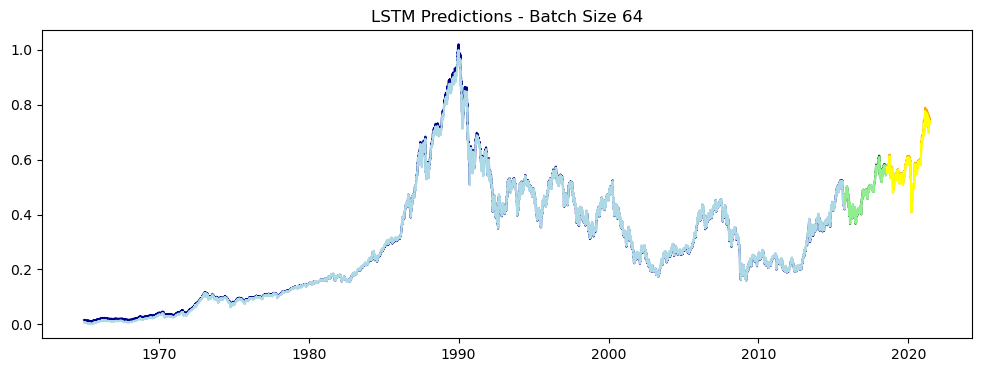

In [86]:
plot_predictions(tokyo_close, train, val, test, lstm_64_train_preds, lstm_64_val_preds, lstm_64_test_preds,
                 "LSTM Predictions - Batch Size 64")

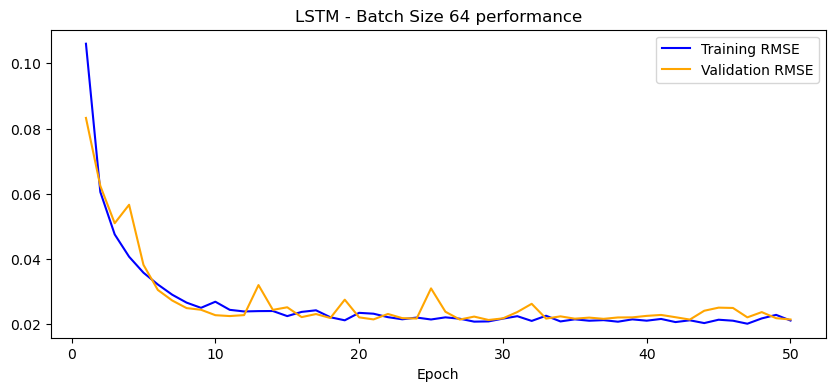

In [87]:
plot_model_performance(lstm_history_64, 'LSTM - Batch Size 64')

#### Results Summary - Round 2

In [88]:
results_2 = pd.concat([results_rnn, results_gru, results_lstm,
                     results_rnn_b64, results_gru_b64, results_lstm_b64
                    ]).set_index("model_name")
results_2

test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
model_name                                                                    
RNN_MODEL          0.0012     0.0345    0.0257    0.0006    0.0239   0.0190   
GRU_MODEL          0.0010     0.0322    0.0222    0.0005    0.0214   0.0158   
LSTM_MODEL         0.0012     0.0350    0.0265    0.0006    0.0242   0.0194   
RNN_MODEL_b64      0.0014     0.0375    0.0295    0.0006    0.0249   0.0201   
GRU_MODEL_b64      0.0010     0.0324    0.0225    0.0005    0.0216   0.0161   
LSTM_MODEL_b64     0.0010     0.0318    0.0213    0.0005    0.0214   0.0157   

                train_loss  train_rmse  train_mae  
model_name                                         
RNN_MODEL           0.0005      0.0219     0.0162  
GRU_MODEL           0.0004      0.0194     0.0121  
LSTM_MODEL          0.0005      0.0212     0.0147  
RNN_MODEL_b64       0.0005      0.0214     0.0138  
GRU_MODEL_b64       0.0004      0.0193     0.0115  
LSTM_MODEL_b64      0.0004      0.0197     0.0122

The increase in batch size to 64 improves the results in test and validation data only for the LSTM, but not for the RNN and GRU as we can see by the test RMSE values.

### CNN-LSTM

Finally, after developing the more simple and standard models, we continue to develop the CNN-LSTM model which was found in the literature to have a better performance with stock price data than other counterparts, namely the models that we already implemented above.

In [89]:
# Define CNN-LSTM's architecture
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, InputLayer

cnn_lstm_model = Sequential()
cnn_lstm_model.add(InputLayer(input_shape=(num_input_features,1)))
cnn_lstm_model.add(Conv1D(filters=32,kernel_size=1,padding="same",activation='tanh'))
cnn_lstm_model.add(MaxPooling1D(pool_size=1, padding="same"))
cnn_lstm_model.add(LSTM(units=64))
cnn_lstm_model.add(Dense(1))

cnn_lstm_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
cnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
_________________________________________________________________


In [90]:
cnn_lstm_model, cnn_lstm_history = get_trained_model('cnn_lstm_model', cnn_lstm_model,
                                                     train_generator, val_generator)

Epoch 1/50
390/390 [==============================] - 29s 71ms/step - loss: 9.3305e-04 - rmse: 0.0313 - mae: 0.0161 - val_loss: 2.0015e-04 - val_rmse: 0.0141 - val_mae: 0.0125
Epoch 2/50
390/390 [==============================] - 24s 61ms/step - loss: 1.0636e-04 - rmse: 0.0103 - mae: 0.0071 - val_loss: 1.0427e-04 - val_rmse: 0.0102 - val_mae: 0.0084
Epoch 3/50
390/390 [==============================] - 24s 62ms/step - loss: 2.2611e-04 - rmse: 0.0150 - mae: 0.0100 - val_loss: 0.0016 - val_rmse: 0.0398 - val_mae: 0.0387
Epoch 4/50
390/390 [==============================] - 26s 66ms/step - loss: 8.8167e-05 - rmse: 0.0094 - mae: 0.0064 - val_loss: 5.9493e-05 - val_rmse: 0.0077 - val_mae: 0.0057
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 1.0219e-04 - rmse: 0.0101 - mae: 0.0067 - val_loss: 9.6711e-05 - val_rmse: 0.0098 - val_mae: 0.0077
Epoch 6/50
390/390 [==============================] - 26s 66ms/step - loss: 7.1846e-05 - rmse: 0.0085 - mae: 0.0058 - val_lo

In [91]:
results_cnn_lstm = evaluate_model(cnn_lstm_model,
                                 "CNN_LSTM_MODEL",
                                 train_generator,
                                 val_generator,
                                 test_generator,
                                 verbose=True)
results_cnn_lstm

Evaluation of CNN_LSTM_MODEL:
21/21 [==============================] - 1s 16ms/step - loss: 6.9353e-05 - rmse: 0.0083 - mae: 0.0062

Test loss: 0.0001 	 | 	test rmse: 0.0083 	 | 	test mae: 0.0062
Val loss: 0.0 	 | 	val rmse: 0.0065 	 | 	val mae: 0.0048
Train loss: 0.0 	 | 	train rmse: 0.0053 	 | 	train mae: 0.0034


model_name  test_loss  test_rmse  test_mae  val_loss  val_rmse  \
0  CNN_LSTM_MODEL     0.0001     0.0083    0.0062       0.0    0.0065   

   val_mae  train_loss  train_rmse  train_mae  
0   0.0048         0.0      0.0053     0.0034

In [92]:
cnn_lstm_train_preds, cnn_lstm_val_preds, cnn_lstm_test_preds = generate_predictions(cnn_lstm_model, train, val, test)

22/22 [==============================] - 0s 5ms/step
Shape of train_preds: (12488, 1)
Shape of val_preds: (693, 1)


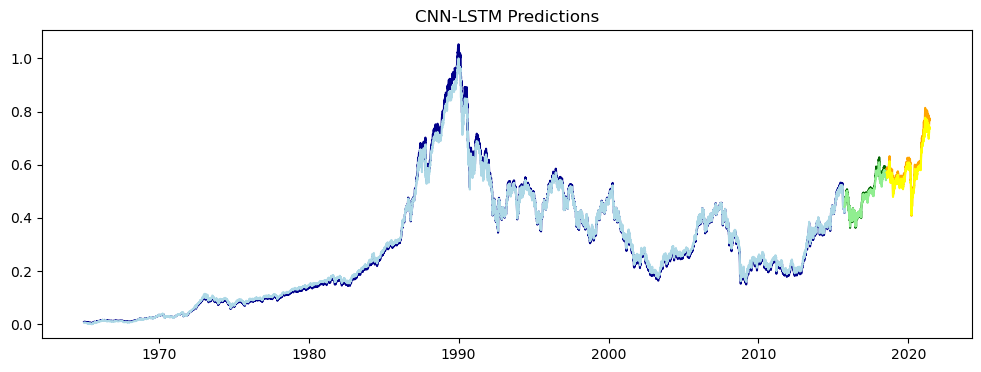

In [93]:
plot_predictions(tokyo_close, train, val, test, cnn_lstm_train_preds, cnn_lstm_val_preds, cnn_lstm_test_preds,
                 "CNN-LSTM Predictions")

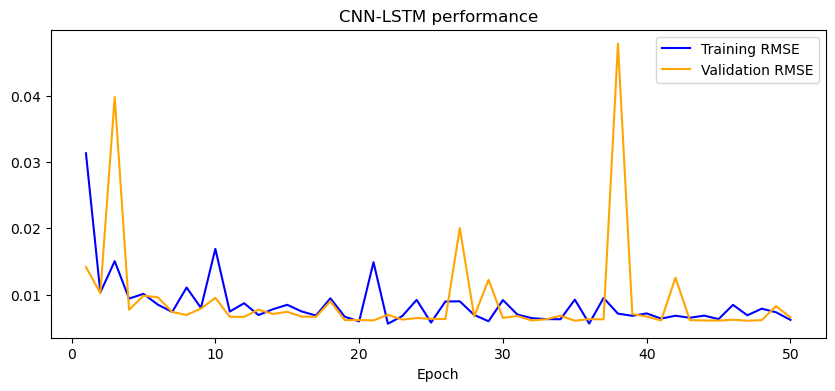

In [94]:
plot_model_performance(cnn_lstm_history, 'CNN-LSTM')

In [95]:
results_3 = pd.concat([results_rnn, results_gru, results_lstm,
                       results_rnn_b64, results_gru_b64, results_lstm_b64,
                       results_cnn_lstm
                      ]).set_index("model_name")
results_3

test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
model_name                                                                    
RNN_MODEL          0.0012     0.0345    0.0257    0.0006    0.0239   0.0190   
GRU_MODEL          0.0010     0.0322    0.0222    0.0005    0.0214   0.0158   
LSTM_MODEL         0.0012     0.0350    0.0265    0.0006    0.0242   0.0194   
RNN_MODEL_b64      0.0014     0.0375    0.0295    0.0006    0.0249   0.0201   
GRU_MODEL_b64      0.0010     0.0324    0.0225    0.0005    0.0216   0.0161   
LSTM_MODEL_b64     0.0010     0.0318    0.0213    0.0005    0.0214   0.0157   
CNN_LSTM_MODEL     0.0001     0.0083    0.0062    0.0000    0.0065   0.0048   

                train_loss  train_rmse  train_mae  
model_name                                         
RNN_MODEL           0.0005      0.0219     0.0162  
GRU_MODEL           0.0004      0.0194     0.0121  
LSTM_MODEL          0.0005      0.0212     0.0147  
RNN_MODEL_b64       0.0005      0.0214     0.0138  
GRU_MODEL_b64       0.0004      0.0193     0.0115  
LSTM_MODEL_b64      0.0004      0.0197     0.0122  
CNN_LSTM_MODEL      0.0000      0.0053     0.0034

### Hyperparameter Tuning

Since the CNN-LSTM was the best model, we are going to tune its hyper parameters.

In [132]:
import keras_tuner as kt

In [133]:
# from keras tuner documentation
def build_model(hp):
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(InputLayer(input_shape=(num_input_features,1)))
    cnn_lstm_model.add(Conv1D(filters=32,kernel_size=1,padding="same",activation='tanh'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, padding="same"))
    cnn_lstm_model.add(LSTM(hp.Choice('units', [64, 128, 256])))
    cnn_lstm_model.add(Dense(1))

    cnn_lstm_model.compile(loss=loss_function,
                           optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                           metrics=metrics)
    return cnn_lstm_model

In [138]:
tuner = kt.GridSearch(build_model,objective='val_loss',seed=seed)

In [148]:
tuner.search(train_generator, validation_data=val_generator, epochs=50)

INFO:tensorflow:Oracle triggered exit


In [140]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0002 summary
Hyperparameters:
units: 128
optimizer: adam
Score: 3.671785816550255e-05

Trial 0000 summary
Hyperparameters:
units: 64
optimizer: adam
Score: 3.677792119560763e-05

Trial 0004 summary
Hyperparameters:
units: 256
optimizer: adam
Score: 3.7227317079668865e-05

Trial 0003 summary
Hyperparameters:
units: 128
optimizer: sgd
Score: 0.00010015264706453308

Trial 0005 summary
Hyperparameters:
units: 256
optimizer: sgd
Score: 0.00010228703467873856

Trial 0001 summary
Hyperparameters:
units: 64
optimizer: sgd
Score: 0.00010379843297414482


In [141]:
model_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters (GRU):", model_best_hps.values)

Best hyperparameters (GRU): {'units': 128, 'optimizer': 'adam'}


### Final Model

In [142]:
final_model = tuner.hypermodel.build(model_best_hps)

In [143]:
# join validation data with train
train_final = np.concatenate((train,val))
train_final

array([[0.00626013],
       [0.00642559],
       [0.00669686],
       ...,
       [0.57203253],
       [0.5640925 ],
       [0.56708733]])

In [144]:
# rebuild generators
train_final_generator = TimeseriesGenerator(train_final, train_final, length=timesteps, batch_size=batch_size)
test_final_generator = TimeseriesGenerator(test, test, length=timesteps, batch_size=batch_size)

In [145]:
hist_f = final_model.fit(train_final_generator, epochs=50)

Epoch 1/50
411/411 [==============================] - 31s 71ms/step - loss: 6.5592e-04 - rmse: 0.0251 - mae: 0.0150
Epoch 2/50
411/411 [==============================] - 30s 73ms/step - loss: 1.0859e-04 - rmse: 0.0104 - mae: 0.0070
Epoch 3/50
411/411 [==============================] - 29s 72ms/step - loss: 1.7692e-04 - rmse: 0.0133 - mae: 0.0088
Epoch 4/50
411/411 [==============================] - 30s 73ms/step - loss: 5.3989e-04 - rmse: 0.0232 - mae: 0.0120
Epoch 5/50
411/411 [==============================] - 29s 71ms/step - loss: 4.9427e-05 - rmse: 0.0070 - mae: 0.0048
Epoch 6/50
411/411 [==============================] - 28s 68ms/step - loss: 4.3645e-05 - rmse: 0.0066 - mae: 0.0045
Epoch 7/50
411/411 [==============================] - 28s 69ms/step - loss: 1.0961e-04 - rmse: 0.0105 - mae: 0.0066
Epoch 8/50
411/411 [==============================] - 29s 69ms/step - loss: 7.6655e-05 - rmse: 0.0088 - mae: 0.0057
Epoch 9/50
411/411 [==============================] - 29s 71ms/step - lo

In [146]:
# save final model in models folder
name = 'final_model'
final_model.save('./models/'+name+'.h5')

In [147]:
final_test_results = final_model.evaluate(test_final_generator)

21/21 [==============================] - 1s 15ms/step - loss: 7.4330e-05 - rmse: 0.0086 - mae: 0.0065


In [149]:
results_3 # before Hyperparameter Tuning

test_loss  test_rmse  test_mae  val_loss  val_rmse  val_mae  \
model_name                                                                    
RNN_MODEL          0.0012     0.0345    0.0257    0.0006    0.0239   0.0190   
GRU_MODEL          0.0010     0.0322    0.0222    0.0005    0.0214   0.0158   
LSTM_MODEL         0.0012     0.0350    0.0265    0.0006    0.0242   0.0194   
RNN_MODEL_b64      0.0014     0.0375    0.0295    0.0006    0.0249   0.0201   
GRU_MODEL_b64      0.0010     0.0324    0.0225    0.0005    0.0216   0.0161   
LSTM_MODEL_b64     0.0010     0.0318    0.0213    0.0005    0.0214   0.0157   
CNN_LSTM_MODEL     0.0001     0.0083    0.0062    0.0000    0.0065   0.0048   

                train_loss  train_rmse  train_mae  
model_name                                         
RNN_MODEL           0.0005      0.0219     0.0162  
GRU_MODEL           0.0004      0.0194     0.0121  
LSTM_MODEL          0.0005      0.0212     0.0147  
RNN_MODEL_b64       0.0005      0.0214     0.0138  
GRU_MODEL_b64       0.0004      0.0193     0.0115  
LSTM_MODEL_b64      0.0004      0.0197     0.0122  
CNN_LSTM_MODEL      0.0000      0.0053     0.0034

### Final Model Results

In [150]:
print('Test scores for final model:')
print('Test loss: ', final_test_results[0], '\nTest RMSE: ', final_test_results[1], '\nTest MAE: ', final_test_results[2])

Test scores for final model:
Test loss:  7.432987331412733e-05 
Test RMSE:  0.008621477521955967 
Test MAE:  0.006499426905065775


In [152]:
train_final_preds = final_model.predict(train_final)

412/412 [==============================] - 1s 3ms/step


In [153]:
test_final_preds = final_model.predict(test)

22/22 [==============================] - 0s 2ms/step


In [154]:
def plot_predictions_final(tokyo_close, train, test,
                           train_preds, test_preds,
                           title, vars_to_plot=["train_preds", "test_preds", "train", "test"]):
    '''
    Plot Predictions with train and test data
    '''
    data_dict = {
                 "train": train, "test": test,
                 "train_preds": train_preds.ravel(), "test_preds": test_preds.ravel()
                }

    datetime_indexes = {
                        "train": tokyo_close[:-split_time].index,
                        "train_preds": tokyo_close[:-split_time].index,
                        "test": tokyo_close[-split_time:].index,
                        "test_preds": tokyo_close[-split_time:].index
                        }
    
    color_code = {
                  "train": "lightblue",
                  "test": "yellow",
                  "train_preds": "darkblue",
                  "test_preds": "orange"
                  }
    
    plt.figure(figsize=(12,4))
    
    for col in vars_to_plot:
        plt.plot(datetime_indexes[col], data_dict[col], color=color_code[col])
        
    
    plt.title(title)
    plt.show()

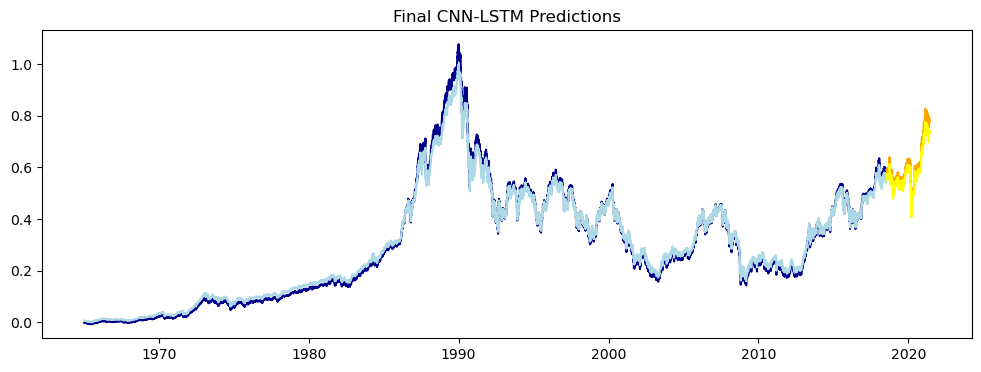

In [155]:
plot_predictions_final(tokyo_close, train_final, test, train_final_preds, test_final_preds,
                       "Final CNN-LSTM Predictions")

In [151]:
# produce requirements.txt
!pip freeze > requirements.txt